In [267]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math 
import os 
from skimage.transform import resize
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report

### DATA EXPLORATION

In [203]:
data_train = pd.read_csv('raw_data/train.txt', sep=' ', header=None)
data_train.columns = ['patient_id', 'filename', 'class', 'source']
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67863 entries, 0 to 67862
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  67863 non-null  object
 1   filename    67863 non-null  object
 2   class       67863 non-null  object
 3   source      67863 non-null  object
dtypes: object(4)
memory usage: 2.1+ MB


In [204]:
data_train.head()

,patient_id,filename,class,source
0,379,1e64990d1b40c1758a2aaa9c7f7a85_jumbo.jpeg,negative,cohen
1,379,7223b8ad031187d9a142d7f7ca02c9_jumbo.jpeg,negative,cohen
2,380,3392dc7d262e28423caca517f98c2e_jumbo.jpeg,negative,cohen
3,380,ec3a480c0926ded74429df416cfb05_jumbo.jpeg,negative,cohen
4,382,a72aeb349a63c79ed24e473c434efe_jumbo.jpg,negative,cohen


In [205]:
data_train['class'].value_counts()

class
positive    57199
negative    10664
Name: count, dtype: int64

In [206]:
data_test = pd.read_csv('raw_data/test.txt', sep=' ', header=None)
data_test.columns = ['patient_id', 'filename', 'class', 'source']
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8482 entries, 0 to 8481
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  8482 non-null   object
 1   filename    8482 non-null   object
 2   class       8482 non-null   object
 3   source      8482 non-null   object
dtypes: object(4)
memory usage: 265.2+ KB


In [207]:
data_test.head()

,patient_id,filename,class,source
0,419639-003251,MIDRC-RICORD-1C-419639-003251-46647-0.png,positive,ricord
1,419639-001464,MIDRC-RICORD-1C-419639-001464-39871-0.png,positive,ricord
2,419639-000918,MIDRC-RICORD-1C-419639-000918-78965-0.png,positive,ricord
3,419639-003318,MIDRC-RICORD-1C-419639-003318-64285-0.png,positive,ricord
4,419639-001015,MIDRC-RICORD-1C-419639-001015-81591-0.png,positive,ricord


In [208]:
data_test['class'].value_counts()

class
positive    4241
negative    4241
Name: count, dtype: int64

In [209]:
data_val = pd.read_csv('raw_data/val.txt', sep=' ', header=None)
data_val.columns = ['patient_id', 'filename', 'class', 'source']
data_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8473 entries, 0 to 8472
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  8473 non-null   object
 1   filename    8473 non-null   object
 2   class       8473 non-null   object
 3   source      8473 non-null   object
dtypes: object(4)
memory usage: 264.9+ KB


In [210]:
data_val['class'].value_counts()

class
positive    4241
negative    4232
Name: count, dtype: int64

In [211]:
# Create samples dataframe to test code faster

data_train_sample = data_train.sample(1000)
data_test_sample = data_test.sample(1000)
data_val_sample = data_val.sample(1000)

patient_id
S312524                                 1
ff3c2e94-b672-4bd2-8073-e9a4b6d9294d    1
ff42dbdc-285e-457d-aa3d-725638fa083b    1
ff47d677-c81f-4847-900b-a2cb12e06c3b    1
S29630                                  1
Name: count, dtype: int64

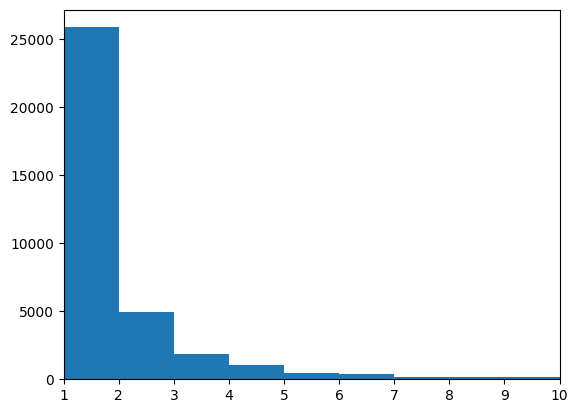

In [212]:
# How many picture by patient_id? 

patient_xray_counts = data_train["patient_id"].value_counts()
plt.hist(counts, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.xlim(right=10, left=1)
patient_xray_counts.tail()


In [213]:
data_train[data_train["patient_id"]=='A860070']['class'].value_counts()

class
positive    236
Name: count, dtype: int64

Plot positive and negative cases

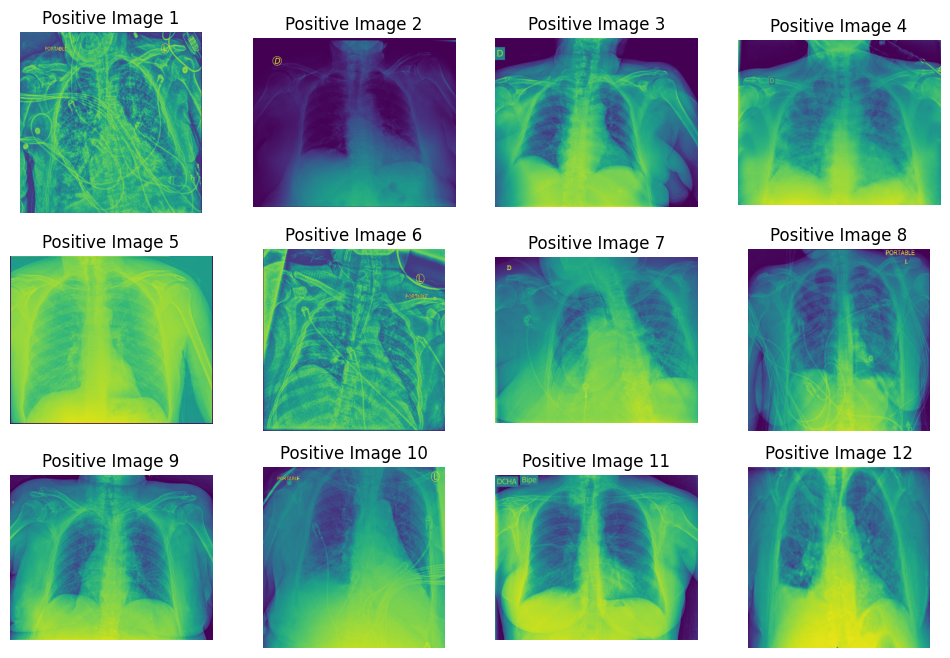

In [214]:
# Plot positive cases 

positive_cases = data_train[data_train['class']=='positive'].sample(12)

fig, axs = plt.subplots(3, 4, figsize=(12, 8))
axs = axs.flatten()

for i, filename in enumerate(positive_cases['filename']):
        filepath = f"raw_data/train/{filename}"
        img = mpimg.imread(filepath)
        axs[i].imshow(img)
        axs[i].axis('off')  # cacher les axes
        axs[i].set_title(f"Positive Image {i+1}")

In [215]:
# Plot negative cases 

positive_cases = data_train[data_train['class']=='negative'].sample(12)

fig, axs = plt.subplots(3, 4, figsize=(12, 8))
axs = axs.flatten()

for i, filename in enumerate(positive_cases['filename']):
        filepath = f"raw_data/train/{filename}"
        img = mpimg.imread(filepath)
        axs[i].imshow(img)
        axs[i].axis('off')  # cacher les axes
        axs[i].set_title(f"Negative Image {i+1}")

Error in callback <function flush_figures at 0x116713c70> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

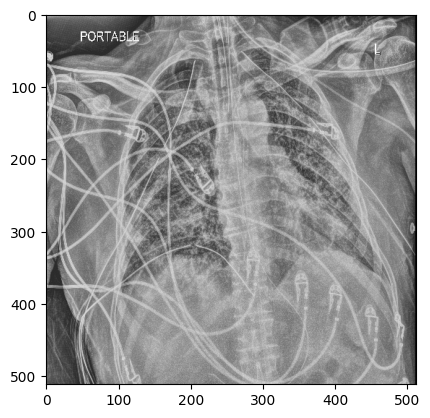

In [ ]:
df = data_train
patient_id = 'A860070'
patient_data = df[df['patient_id'] == patient_id]
line = patient_data.iloc[0]
img_path = 'raw_data/train/'+line['filename']
img = mpimg.imread(img_path)
plt.imshow(img, cmap=plt.cm.gray)
plt.title = line['class']

In [ ]:
# Let's have a look to image size and update df 

def image_size(row, set):
    filepath = f"raw_data/{set}/{row['filename']}"
    img = mpimg.imread(filepath)
    size_bytes = os.path.getsize(filepath)
    return img.shape[0], img.shape[1], img.ndim, size_bytes / 1024


In [ ]:
data_train_sample[['height', 'width', 'channels', 'img_size_kb']] = data_train_sample.apply(
    lambda row: pd.Series(image_size(row, 'train')),
    axis=1
)

In [ ]:
data_train_sample['channels'].value_counts()

channels
2.0    998
3.0      2
Name: count, dtype: int64

In [ ]:
data_train_sample

,patient_id,filename,class,source,height,width,channels,img_size_kb
39246,S312275,sub-S312275_ses-E55334_run-1_bp-chest_vp-ap_cr...,positive,bimcv,841.0,1024.0,2.0,336.855469
12386,A103624,A103624-01-15-1901-NA-CHEST_AP_PORT-09253-1.00...,positive,stonybrook,512.0,512.0,2.0,74.133789
50159,S319136,sub-S319136_ses-E39510_run-1_bp-chest_vp-pa_cr...,positive,bimcv,1000.0,1024.0,2.0,476.569336
10436,be379186-93d4-4aa0-b4ae-0c86c9f6b31e,be379186-93d4-4aa0-b4ae-0c86c9f6b31e.png,negative,rsna,1024.0,1024.0,2.0,281.576172
12486,A264703,A264703-01-27-1901-NA-CHEST_AP_VIEWONLY-48655-...,positive,stonybrook,512.0,512.0,2.0,136.356445
...,...,...,...,...,...,...,...,...
32132,S308649,sub-S308649_ses-E33986_run-1_bp-chest_vp-ap_dx...,positive,bimcv,843.0,1024.0,2.0,357.649414
5147,e30bd362-7a11-4797-adb2-708520cdfb8d,e30bd362-7a11-4797-adb2-708520cdfb8d.png,negative,rsna,1024.0,1024.0,2.0,358.839844
43963,S315073,sub-S315073_ses-E50499_run-1_bp-chest_vp-ap_dx...,positive,bimcv,1024.0,1023.0,2.0,474.584961
49840,S318906,sub-S318906_ses-E39047_run-1_bp-chest_vp-ap_cr...,positive,bimcv,843.0,1024.0,2.0,368.182617


In [ ]:
data_test_sample[['height', 'width', 'channels', 'img_size_kb']] = data_test_sample.apply(
    lambda row: pd.Series(image_size(row, 'test')),
    axis=1
)

data_test_sample['channels'].value_counts()

channels
2.0    1000
Name: count, dtype: int64

In [ ]:
data_val_sample[['height', 'width', 'channels', 'img_size_kb']] = data_val_sample.apply(
    lambda row: pd.Series(image_size(row, 'val')),
    axis=1
)

data_val_sample['channels'].value_counts()

channels
2.0    994
3.0      6
Name: count, dtype: int64

There are only: 
- 0.4% of colour pictures in train set 
- 0.4% of colour pictures in val set
- None in the test set

We can exclude 3Dim pictures from our model.


(array([ 1.,  1.,  6.,  2.,  0.,  5., 15., 26., 29., 20.,  7.,  1.,  1.,
         3.,  3., 10., 22., 28., 19.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  2.,  6.,  3.,  3.,  5.,  6.,  4.,
         6.,  2.,  2., 10., 16.,  9., 12., 22., 29., 27., 26., 31., 28.,
        28., 36., 24., 25., 26., 25., 31., 34., 24., 27., 28., 19., 18.,
        22., 20., 19., 16., 19., 17., 10., 15., 10., 10.,  6.,  4.,  6.,
         6.,  2.,  4.,  4.,  6.,  0.,  0.,  2.,  1.,  0.,  0.,  0.,  1.,
         1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 13.140625  ,  20.04501953,  26.94941406,  33.85380859,
         40.75820313,  47.66259766,  54.56699219,  61.47138672,
         68.37578125,  75.28017578,  82.18457031,  89.08896484,
         95.99335938, 102.89775391, 109.80214844, 116.70654297,
        123.6109375 , 130.51533203, 137.41972656, 144.32412109,
        151.22851562, 158.13291016, 165.03730469, 171.94169922,
        178.84609375, 185.75048828, 192.65488281, 

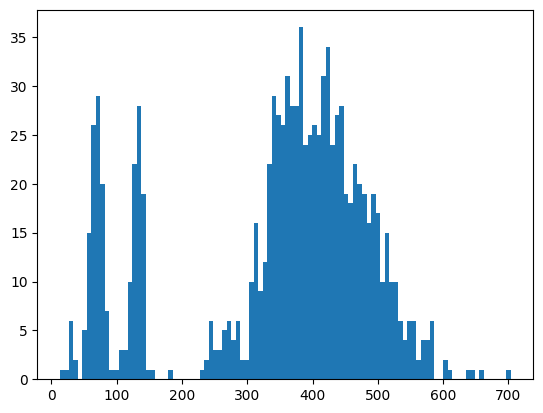

In [ ]:
plt.hist(data_train_sample['img_size_kb'], bins=100)

(array([  7.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,
        183.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   2.,
          7.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,
          1.,   1.,   3.,   1.,   2.,   3.,   2.,   2.,   4.,   5.,  10.,
        754.]),
 array([ 255.  ,  262.69,  270.38,  278.07,  285.76,  293.45,  301.14,
         308.83,  316.52,  324.21,  331.9 ,  339.59,  347.28,  354.97,
         362.66,  370.35,  378.04,  385.73,  393.42,  401.11,  408.8 ,
         416.49,  424.18,  431.87,  439.56,  447.25,  454.94,  462.63,
         470.32,  478.01,  485.7 ,

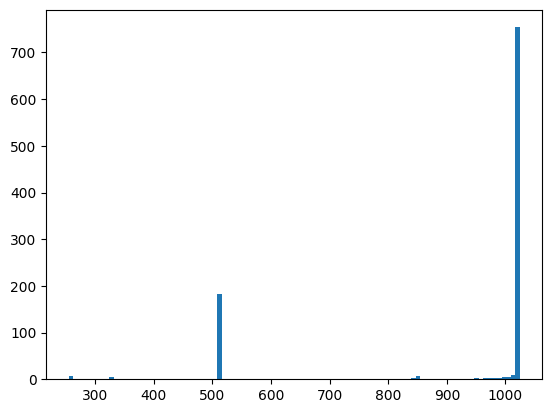

In [ ]:
plt.hist(data_train_sample['width'], bins=100)

(array([  7.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
        183.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   1.,   1.,   3.,
          3.,   1.,   1.,   2.,   3.,   0.,   3.,   2.,  15.,   3., 256.,
        130.,  15.,   3.,   4.,   6.,   2.,   3.,   3.,   3.,   3.,   4.,
          3.,   2.,   5.,   5.,   3.,   5.,   5.,   1.,   7.,   5.,   4.,
        285.]),
 array([ 249.  ,  256.75,  264.5 ,  272.25,  280.  ,  287.75,  295.5 ,
         303.25,  311.  ,  318.75,  326.5 ,  334.25,  342.  ,  349.75,
         357.5 ,  365.25,  373.  ,  380.75,  388.5 ,  396.25,  404.  ,
         411.75,  419.5 ,  427.25,  435.  ,  442.75,  450.5 ,  458.25,
         466.  ,  473.75,  481.5 ,

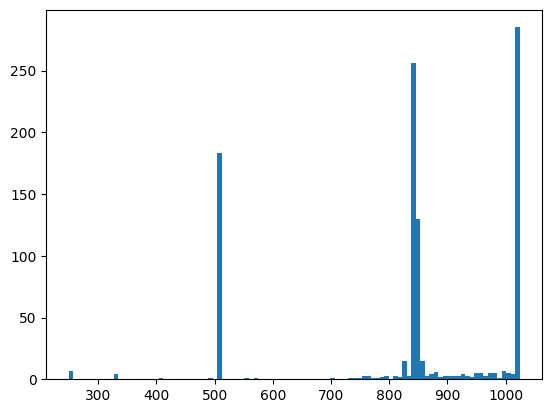

In [ ]:
plt.hist(data_train_sample['height'], bins=100)

In [ ]:
def image_ratio(width, height):
    ratios = {
        "1:1": 1/1,
        "4:3": 4/3,
        "3:2": 3/2,
        "16:9": 16/9,
        "21:9": 21/9,
        "5:4": 5/4
    }

    actual_ratio = width / height

    closest = min(ratios.items(), key=lambda x: abs(actual_ratio - x[1]))

    return closest[0]

In [ ]:
data_train_sample['image_ratio'] = data_train_sample.apply(lambda row: image_ratio(row['width'], row['height']), axis=1)
data_train_sample.head()

,patient_id,filename,class,source,height,width,channels,img_size_kb,image_ratio
39246,S312275,sub-S312275_ses-E55334_run-1_bp-chest_vp-ap_cr...,positive,bimcv,841.0,1024.0,2.0,336.855469,5:4
12386,A103624,A103624-01-15-1901-NA-CHEST_AP_PORT-09253-1.00...,positive,stonybrook,512.0,512.0,2.0,74.133789,1:1
50159,S319136,sub-S319136_ses-E39510_run-1_bp-chest_vp-pa_cr...,positive,bimcv,1000.0,1024.0,2.0,476.569336,1:1
10436,be379186-93d4-4aa0-b4ae-0c86c9f6b31e,be379186-93d4-4aa0-b4ae-0c86c9f6b31e.png,negative,rsna,1024.0,1024.0,2.0,281.576172,1:1
12486,A264703,A264703-01-27-1901-NA-CHEST_AP_VIEWONLY-48655-...,positive,stonybrook,512.0,512.0,2.0,136.356445,1:1


In [ ]:
data_train_sample['image_ratio'].value_counts()

image_ratio
1:1    519
5:4    476
4:3      4
3:2      1
Name: count, dtype: int64

In [ ]:
from skimage import io, color, measure, filters
from skimage.measure import shannon_entropy
import numpy as np

def full_metrics(row, dataset):
    filepath = f"raw_data/{dataset}/{row['filename']}"
    img = io.imread(filepath)

    if img.ndim == 3:
        img = color.rgb2gray(img)

    brightness = np.mean(img)
    contrast = np.std(img)
    entropy = shannon_entropy(img)
    lap = filters.laplace(img)
    sharpness = lap.var()
    

    return brightness, contrast, entropy, sharpness

In [ ]:
data_train_sample[['brightness', 'contrast', 'entropy', 'sharpness']] = data_train_sample.apply(lambda row: pd.Series(full_metrics(row, 'train')), axis=1)
#full_metrics(data_train_sample.iloc[0], 'train')

In [ ]:
data_train_sample.head()

,patient_id,filename,class,source,height,width,channels,img_size_kb,image_ratio,brightness,contrast,entropy,sharpness
39246,S312275,sub-S312275_ses-E55334_run-1_bp-chest_vp-ap_cr...,positive,bimcv,841.0,1024.0,2.0,336.855469,5:4,165.519240,80.044901,7.153692,0.003483
12386,A103624,A103624-01-15-1901-NA-CHEST_AP_PORT-09253-1.00...,positive,stonybrook,512.0,512.0,2.0,74.133789,1:1,117.740284,56.247956,7.643861,0.004904
50159,S319136,sub-S319136_ses-E39510_run-1_bp-chest_vp-pa_cr...,positive,bimcv,1000.0,1024.0,2.0,476.569336,1:1,186.745359,49.814962,7.159809,0.001278
10436,be379186-93d4-4aa0-b4ae-0c86c9f6b31e,be379186-93d4-4aa0-b4ae-0c86c9f6b31e.png,negative,rsna,1024.0,1024.0,2.0,281.576172,1:1,157.734375,39.544873,6.994555,0.000666
12486,A264703,A264703-01-27-1901-NA-CHEST_AP_VIEWONLY-48655-...,positive,stonybrook,512.0,512.0,2.0,136.356445,1:1,140.256901,40.438464,7.165741,0.032416


Text(0.5, 1.0, 'Sharpness')

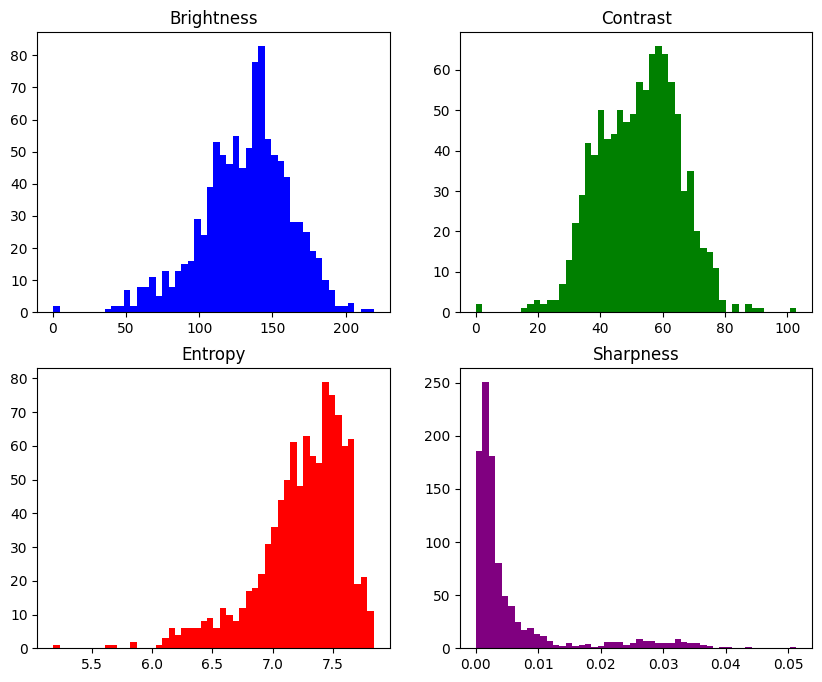

In [ ]:
bins=50
fig, axs = plt.subplots(2, 2, figsize=(10,8)) 

axs[0,0].hist(data_train_sample['brightness'], color='blue', bins=bins)
axs[0,0].set_title("Brightness")

axs[0,1].hist(data_train_sample['contrast'], color='green', bins=bins)
axs[0,1].set_title("Contrast")

axs[1,0].hist(data_train_sample['entropy'], color='red', bins=bins)
axs[1,0].set_title("Entropy")

axs[1,1].hist(data_train_sample['sharpness'], color='purple', bins=bins)
axs[1,1].set_title("Sharpness")


### Baseline Model - PCA - Model Exploration

In [286]:
data_train_sample.shape, data_val_sample.shape, data_test_sample.shape

((1000, 4), (1000, 4), (1000, 4))

In [285]:
# Build target
y_train_sample = data_train_sample['class']
y_train_sample = y_train_sample.map({"negative": 0, "positive": 1})
y_train_sample

25330    1
61260    1
50426    1
41869    1
41737    1
        ..
38407    1
27722    1
54603    1
13184    1
53330    1
Name: class, Length: 1000, dtype: int64

In [290]:
def flatten_and_resize_image(filename, dataset):
    # Flatten and resize an image to 256 x 256 pixels, grayscale 
    
    filepath = f"raw_data/{dataset}/{filename}"
    img = mpimg.imread(filepath)
    
    # Convert to grayscale if rgb image    
    if img.ndim ==3:
        img = color.rgb2gray(img[:, :, :3])
    
    # Resize to 256 x 256
    img_resized = resize(img, (256, 256), anti_aliasing=True)
   
    return img_resized.flatten()

In [ ]:
# Build X_train with flattened images of 256 x 256

X_train_sample = data_train_sample.apply(lambda row: flatten_and_resize_image(row['filename'], 'train'), axis=1)
X_train_sample = pd.DataFrame(X_train_sample.tolist())


In [291]:
X_train_sample.head()


,0,1,2,3,4,5,6,7,8,9,...,65526,65527,65528,65529,65530,65531,65532,65533,65534,65535
0,0.054629,0.049615,0.081263,0.063535,0.078020,0.090117,0.059529,0.048357,0.075303,0.089558,...,9.219304e-02,0.072414,0.055617,0.097669,0.089776,0.094022,0.075913,0.072053,0.081160,0.086807
1,0.269808,0.272764,0.293018,0.383394,0.546373,0.557777,0.551353,0.575071,0.555359,0.498616,...,6.247828e-02,0.061605,0.063505,0.161378,0.098365,0.063035,0.102751,0.210998,0.176176,0.237415
2,0.020996,0.018505,0.018634,0.018076,0.018043,0.018837,0.018787,0.018493,0.018466,0.018889,...,5.055551e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.715720e-01,0.216707,0.172830,0.154932,0.115734,0.047441,0.004632,0.000009,0.000000,0.000000
4,0.003102,0.006163,0.004297,0.003858,0.003789,0.002708,0.002908,0.002527,0.002093,0.001898,...,4.936220e-01,0.611210,0.593961,0.485836,0.518788,0.501992,0.568228,0.598962,0.481075,0.290207


In [292]:
# Build PCA Model and check PCA Components

pca = PCA(n_components=250).fit(X_train_sample)
data_projected = pca.transform(X_train_sample)

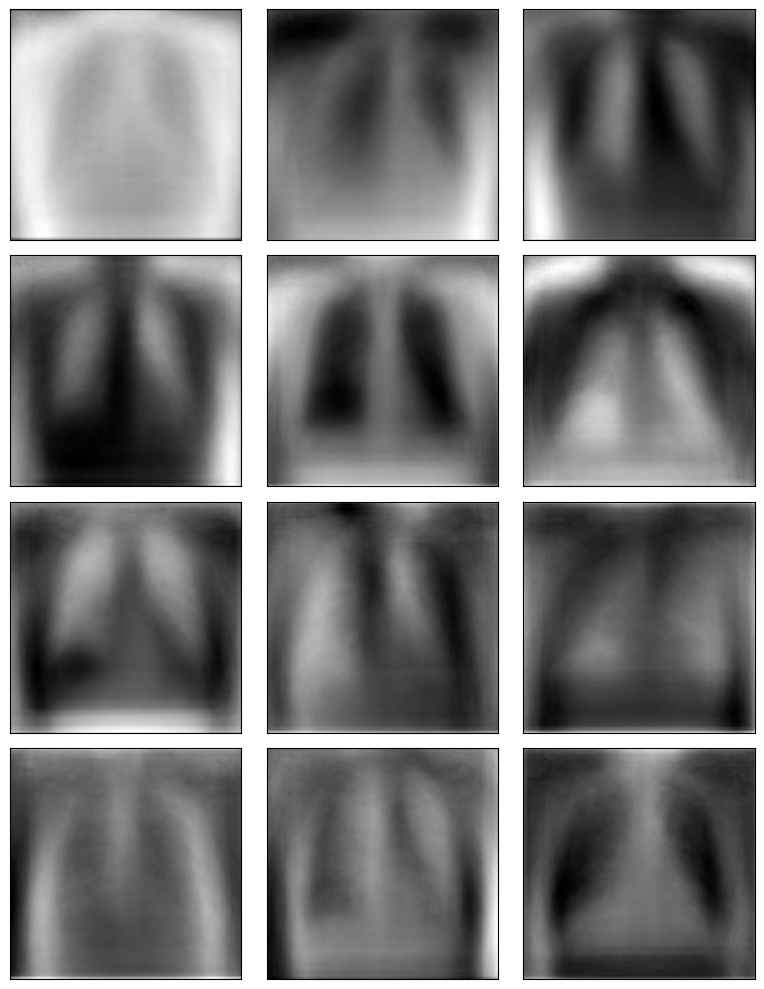

In [249]:
plt.figure(figsize=(8, 10))  # good size for 4x3 layout

for i in range(12):
    img = pca.components_[i].reshape(256, 256)
    
    plt.subplot(4, 3, i + 1)   # 4 rows, 3 columns
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

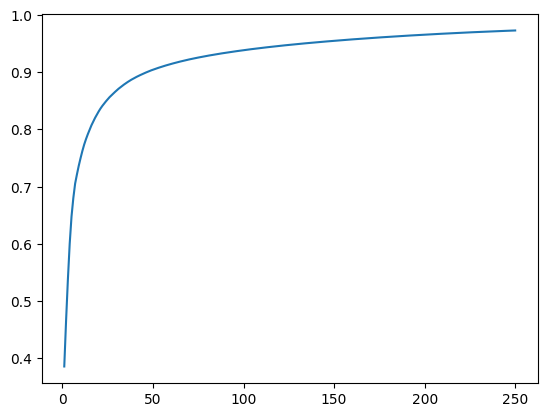

In [251]:
plt.plot(range(1, 251), np.cumsum(pca.explained_variance_ratio_))

In [293]:
# Choose optimized number of PCA Components - Step 1

pipeline = make_pipeline(PCA(), SVC())

grid = {'pca__n_components': [50, 100, 200, 300]}
search = GridSearchCV(pipeline, param_grid=grid, cv=5)

search.fit(X_train_sample, y_train_sample)
best_model = search.best_estimator_
best_model

,steps,"[('pca', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,n_components,50
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10


In [294]:
# Choose optimized number of PCA Components - Step 1

grid = {'pca__n_components': [1, 10, 30, 40, 50, 60, 70, 80]}
search = GridSearchCV(pipeline, param_grid=grid, cv=5)

search.fit(X_train_sample, y_train_sample)
best_model = search.best_estimator_
best_model

,steps,"[('pca', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,n_components,30
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10


In [295]:
# Evaluating model performance on sample
# Construct test dataset and target 
y_test_sample = data_test_sample['class'].map({"negative": 0, "positive": 1})
X_test_sample = data_test_sample.apply(lambda row: flatten_and_resize_image(row['filename'], 'test'), axis=1)
X_test_sample = pd.DataFrame(X_test_sample.tolist())

In [296]:
y_pred = best_model.predict(X_test_sample)
print(classification_report(y_test_sample, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.02      0.04       493
           1       0.51      0.99      0.67       507

    accuracy                           0.51      1000
   macro avg       0.60      0.51      0.36      1000
weighted avg       0.60      0.51      0.36      1000



In [301]:
# Radical Baseline
positive_test_share = y_train_sample.sum() / y_train_sample.size
positive_test_share

np.float64(0.843)

In [302]:
y_pred_basic = np.random.choice([0, 1], size=1000, p=[1 - positive_test_share, positive_test_share])
print(classification_report(y_test_sample, y_pred_basic))

              precision    recall  f1-score   support

           0       0.51      0.16      0.24       493
           1       0.51      0.86      0.64       507

    accuracy                           0.51      1000
   macro avg       0.51      0.51      0.44      1000
weighted avg       0.51      0.51      0.44      1000



### Baseline PCA - Full Model

In [303]:
data_train.shape, data_test.shape

((67863, 4), (8482, 4))

In [304]:
y_train = data_train['class'].map({"negative": 0, "positive": 1})
y_test = data_test['class'].map({"negative": 0, "positive": 1})

In [ ]:
X_train = data_train.apply(lambda row: flatten_and_resize_image(row['filename'], 'train'), axis=1)
X_train = pd.DataFrame(X_train.tolist())

X_test = data_test.apply(lambda row: flatten_and_resize_image(row['filename'], 'test'), axis=1)
X_test = pd.DataFrame(X_test.tolist())